<a href="https://colab.research.google.com/github/lakatosgabor/CRM-System/blob/master/dolgozo_ertekeles_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torch

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt

from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image

import seaborn as sns

In [3]:
model_name = "NYTK/husst-puli-bert-large-hungarian"   #NYTK/hucola-puli-bert-large-hungarian NYTK/husst-puli-bert-large-hungarian NYTK/hurte-puli-bert-large-hungarian
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/769k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

In [4]:
# Koszinus távolság számítása
def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    distance = 1 - similarity
    return distance

In [5]:
# Szövegek, amelyeket be akarunk ágyazni
# fizetés emelés | kirugás | oktatni kell
texts = ['Amennyiben egy dolgozó kiemelkedő teljesítményt nyújtott a munkakörében és hozzájárult a cég sikeréhez, valamint megfelelő módon teljesítette az elvárt feladatait és célkitűzéseit, akkor indokolt lehet számára egy fizetés emelés megfontolása. Az értékelés során figyelembe kell venni a dolgozó teljesítményét, hozzáállását, munkabírását és az általa elért eredményeket, valamint összhangban kell lennie a cég jelenlegi politikájával és forrásai lehetőségeivel.',
        'Egy alkalmazottat lehet ki kell rúgni, ha az általa nyújtott teljesítmény nem felel meg a munkakörére vagy a cég elvárásaira, és az erre irányuló visszajelzések vagy támogatás ellenére sem mutat javulást. Az alkalmazott visszaélést követ el, sérti a vállalati szabályzatot vagy etikai normákat, vagy olyan súlyosan megsérti a cég belső szabályait vagy az alkalmazotti szerződést, ami megengedhetetlen a folytatott munkaviszony szempontjából. Továbbá, ha az adott munkakör megszűnik vagy az alkalmazott nem képes vagy hajlandó megfelelni az új munkakör feltételeinek vagy elvárásainak, az is indokolhatja az elbocsátást.', 'Egy személyt oktatásra szorulónak tekinthetünk, ha az adott területen vagy témakörben hiányosságai vannak, és nincs megfelelő ismerete vagy készsége az elvárt szinten való teljesítményhez vagy hatékony munkavégzéshez. Az oktatásra szoruló személy általában nyitott az új ismeretek megszerzésére és fejlesztésére, és hajlandó tanulni és javítani a tudását vagy készségeit az adott területen. Emellett az oktatásra szoruló személy gyakran képes és hajlandó elfogadni segítséget, tanácsot vagy képzést annak érdekében, hogy fejlessze a tudását és készségeit.']

In [6]:
# Szövegek beágyazása
text_embeddings = []
for text in texts:
    # Tokenizálás és modellezés
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=False)
    with torch.no_grad():
        outputs = model(**inputs)
    # Az utolsó réteg kimenetét használjuk vektorokként
    vector = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    text_embeddings.append(vector)

In [27]:
text_embeddings2 = []
# Tokenizálás és modellezés

query = "A dolgozó semmihet nem ért. Naponta többször cigizik. Sokat lóg a munkából. Rendszeresen elkésík. Feladatait nem tudja ellátni, rengeteg hibát vét."
inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=False)
with torch.no_grad():
    outputs = model(**inputs)
# Az utolsó réteg kimenetét használjuk vektorokként
vector = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
text_embeddings2.append(vector)

# Koszinus távolságok számítása és normalizálása
text_distances = []
text_pairs = []

for i, vec1 in enumerate(text_embeddings):
    for j, vec2 in enumerate(text_embeddings2):
        distance = cosine_distance(vec1, vec2)
        text_distances.append(distance)
        text_pairs.append((texts[i], texts[j]))


# Normalizálás
text_normalized_distances = (text_distances - np.min(text_distances)) / (np.max(text_distances) - np.min(text_distances))



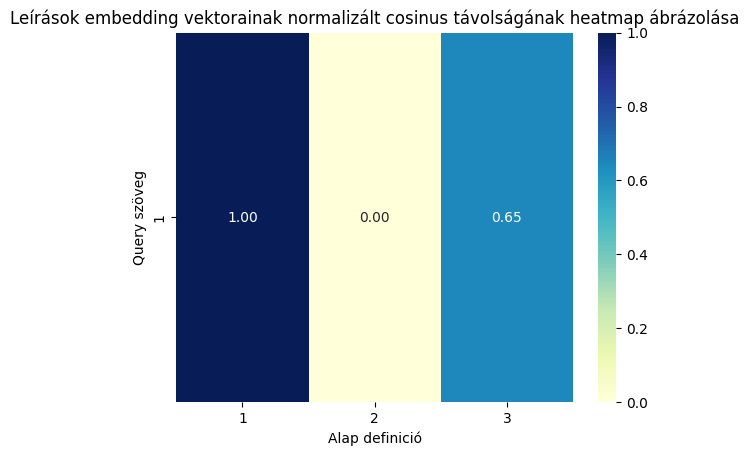

Query szöveg:  A dolgozó semmihet nem ért. Naponta többször cigizik. Sokat lóg a munkából. Rendszeresen elkésík. Feladatait nem tudja ellátni, rengeteg hibát vét.


ALap definiciók:
1 Amennyiben egy dolgozó kiemelkedő teljesítményt nyújtott a munkakörében és hozzájárult a cég sikeréhez, valamint megfelelő módon teljesítette az elvárt feladatait és célkitűzéseit, akkor indokolt lehet számára egy fizetés emelés megfontolása. Az értékelés során figyelembe kell venni a dolgozó teljesítményét, hozzáállását, munkabírását és az általa elért eredményeket, valamint összhangban kell lennie a cég jelenlegi politikájával és forrásai lehetőségeivel.
2 Egy alkalmazottat lehet ki kell rúgni, ha az általa nyújtott teljesítmény nem felel meg a munkakörére vagy a cég elvárásaira, és az erre irányuló visszajelzések vagy támogatás ellenére sem mutat javulást. Az alkalmazott visszaélést követ el, sérti a vállalati szabályzatot vagy etikai normákat, vagy olyan súlyosan megsérti a cég belső szabályait vagy a

In [31]:
data = text_normalized_distances.reshape(1,3)

# Heatmap létrehozása seaborn segítségével
sns.heatmap(data, annot=True, cmap='YlGnBu', fmt='.2f', xticklabels=[1,2,3], yticklabels=[1])

# Tengelycímkék beállítása
plt.xlabel('Alap definició')
plt.ylabel('Query szöveg')
plt.title('Leírások embedding vektorainak normalizált cosinus távolságának heatmap ábrázolása')

# Diagram megjelenítése
plt.show()

print("Query szöveg: ", query)
print("\n")
print("ALap definiciók:")
for idx, text in enumerate(texts):
    print(idx + 1, text)


In [32]:
# Számok növekvő sorrendben
rendezett_szamok = sorted(text_normalized_distances)

# Számok szerinti indexek meghatározása
indexek = sorted(range(len(text_normalized_distances)), key=lambda k: text_normalized_distances[k])

# Szövegek átrendezése az indexek alapján
rendezett_szovegek = [texts[i] for i in indexek]


for i in range(3):
  print(round((1 - rendezett_szamok[i]) * 100, 2),"% -", rendezett_szovegek[i])


100.0 % - Egy alkalmazottat lehet ki kell rúgni, ha az általa nyújtott teljesítmény nem felel meg a munkakörére vagy a cég elvárásaira, és az erre irányuló visszajelzések vagy támogatás ellenére sem mutat javulást. Az alkalmazott visszaélést követ el, sérti a vállalati szabályzatot vagy etikai normákat, vagy olyan súlyosan megsérti a cég belső szabályait vagy az alkalmazotti szerződést, ami megengedhetetlen a folytatott munkaviszony szempontjából. Továbbá, ha az adott munkakör megszűnik vagy az alkalmazott nem képes vagy hajlandó megfelelni az új munkakör feltételeinek vagy elvárásainak, az is indokolhatja az elbocsátást.
35.37 % - Egy személyt oktatásra szorulónak tekinthetünk, ha az adott területen vagy témakörben hiányosságai vannak, és nincs megfelelő ismerete vagy készsége az elvárt szinten való teljesítményhez vagy hatékony munkavégzéshez. Az oktatásra szoruló személy általában nyitott az új ismeretek megszerzésére és fejlesztésére, és hajlandó tanulni és javítani a tudását vagy 